# Credit Card Default Prediction

This worksheet aims to predict if a given customer/ client will default on the next upcoming payment or not basis the historical data of past 6 months.

I am using three machine learning models:
- Logistic Regression
- Support Vector Machine 
- Neural Network (MLPClassifier)

Source: https://www.youtube.com/watch?v=kn5hVBR40eo

## Importing Libraries Required

In [34]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

## Getting the Data

In [2]:
# Reading the data
df = pd.read_excel('default of credit card clients.xls', 
                   skiprows=1)

In [3]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


## Initial Data Exploration

In [6]:
# Checking for any missing values and the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

**Comments:** There are no missing values found and there are no object columns.

## Visualising the Data

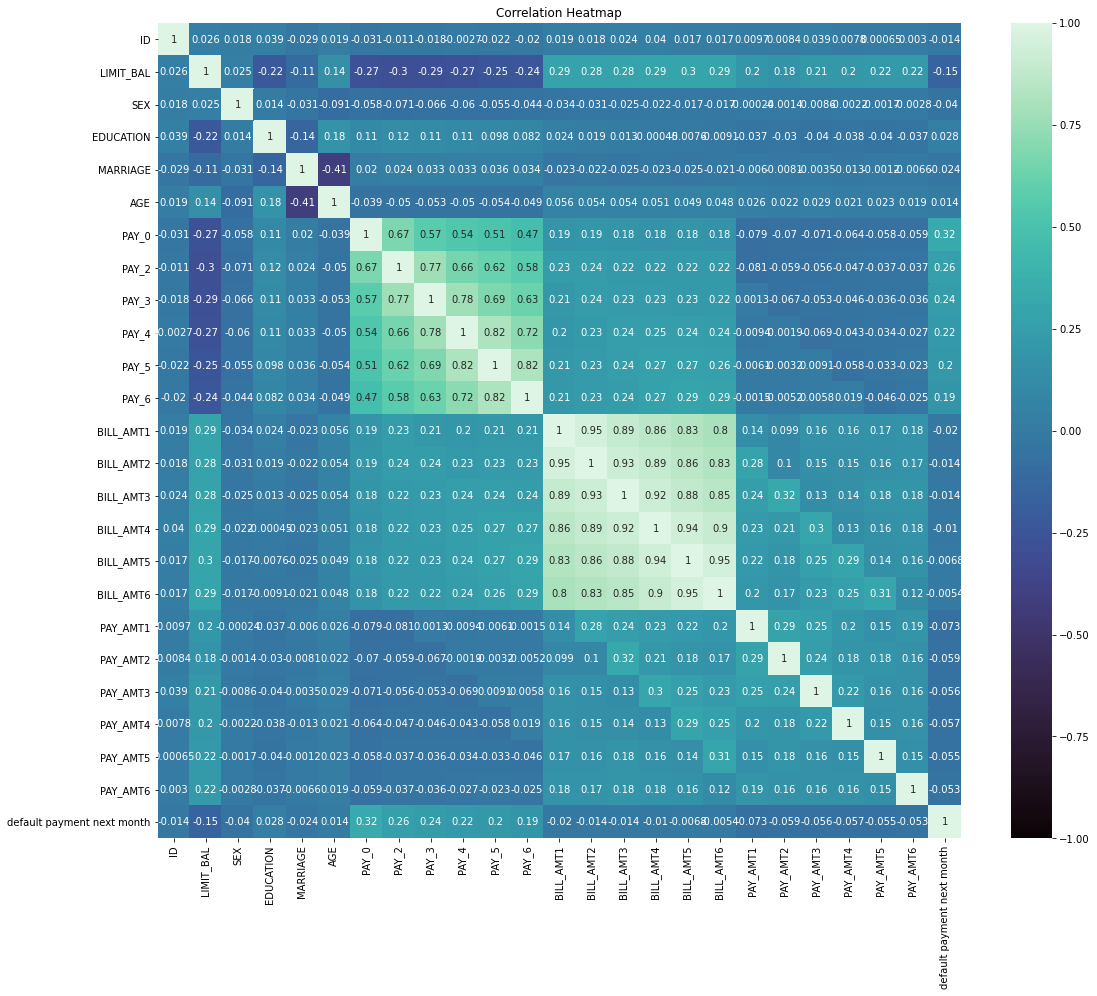

In [5]:
# Checking the correlation for each variables
corr = df.corr()

plt.figure(figsize=(18, 15))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.title("Correlation Heatmap")
plt.show()

**Comments:** 
- Ignore the ID column as it does not say much
- BILL_AMT1 to BILL_AMT6 variables seems to be highly correlated than others
- Variables PAY_0 to PAY_6 is ordinal variable as it says how late the customer/ client is in their payments
- Age and Marriage is negatively correlated but Marriage is a nominal feature as there is no ordering in them so ignoring that.

## Performing Preprocessing Steps

In [19]:
{'EDUCATION':'EDU'}.items()

dict_items([('EDUCATION', 'EDU')])

In [18]:
pd.get_dummies(X['EDUCATION'], prefix = 'EDU')

,EDU_0,EDU_1,EDU_2,EDU_3,EDU_4,EDU_5,EDU_6
0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
29995,0,0,0,1,0,0,0
29996,0,0,0,1,0,0,0
29997,0,0,1,0,0,0,0
29998,0,0,0,1,0,0,0


In [20]:
#each unique value as its own column and own feature
def onehot_encode(data, column_dict):
    data = data.copy()
    
    for column, prefix in column_dict.items():
        dummies= pd.get_dummies(data[column], prefix= prefix)
        data = pd.concat([data, dummies], axis=1)
        data = data.drop(column, axis=1)
    return data
    

In [27]:
def preprocess_inputs(data):
    data = data.copy()
    
    # Drop 'ID' column- This is not giving any useful info as this is just an ID column
    data = data.drop('ID', axis = 1)
    
    data = onehot_encode(
    df,
    {
        'EDUCATION': 'EDU',
        'MARRIAGE': 'MAR'
    }
    )
    
    #Splitting the data to X, y
    y = data['default payment next month'].copy()
    X = data.drop('default payment next month', axis = 1).copy()
    
    # Scaling the data
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
    
    return X, y

In [28]:
X, y = preprocess_inputs(df)

In [29]:
X

,ID,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,EDU_1,EDU_2,EDU_3,EDU_4,EDU_5,EDU_6,MAR_0,MAR_1,MAR_2,MAR_3
0,-1.731993,-1.136720,0.810161,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,-1.486041,...,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326
1,-1.731878,-0.365981,0.810161,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,1.992316,...,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326
2,-1.731762,-0.597202,0.810161,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,...,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326
3,-1.731647,-0.905498,0.810161,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,...,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326
4,-1.731531,-0.905498,-1.234323,2.334029,-0.874991,0.111736,-0.696663,0.188746,0.234917,0.253137,...,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1.731531,0.404759,-1.234323,0.381275,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,...,-0.738375,-0.937295,2.258602,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326
29996,1.731647,-0.134759,-1.234323,0.815221,-0.874991,-0.723570,-0.696663,-0.666599,0.234917,0.253137,...,-0.738375,-0.937295,2.258602,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326
29997,1.731762,-1.059646,-1.234323,0.164303,3.574267,2.617654,1.809921,-0.666599,0.234917,0.253137,...,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326
29998,1.731878,-0.674276,-1.234323,0.598248,0.904712,-0.723570,0.138865,0.188746,0.234917,-0.616452,...,-0.738375,-0.937295,2.258602,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326


In [30]:
y

0        1
1        1
2        0
3        0
4        0
        ..
29995    0
29996    0
29997    1
29998    1
29999    1
Name: default payment next month, Length: 30000, dtype: int64

In [31]:
{column: len(X[column].unique()) for column in X.columns}

{'ID': 30000,
 'LIMIT_BAL': 81,
 'SEX': 2,
 'AGE': 56,
 'PAY_0': 11,
 'PAY_2': 11,
 'PAY_3': 11,
 'PAY_4': 11,
 'PAY_5': 10,
 'PAY_6': 10,
 'BILL_AMT1': 22723,
 'BILL_AMT2': 22346,
 'BILL_AMT3': 22026,
 'BILL_AMT4': 21548,
 'BILL_AMT5': 21010,
 'BILL_AMT6': 20604,
 'PAY_AMT1': 7943,
 'PAY_AMT2': 7899,
 'PAY_AMT3': 7518,
 'PAY_AMT4': 6937,
 'PAY_AMT5': 6897,
 'PAY_AMT6': 6939,
 'EDU_0': 2,
 'EDU_1': 2,
 'EDU_2': 2,
 'EDU_3': 2,
 'EDU_4': 2,
 'EDU_5': 2,
 'EDU_6': 2,
 'MAR_0': 2,
 'MAR_1': 2,
 'MAR_2': 2,
 'MAR_3': 2}

- Sex variable is a binary feature so no transformation required
- Education and Marriage needs to be ordered as there is some issues with categorisation.

## Training the Model

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=123)

In [40]:
models = {
    LogisticRegression(): "   Logistic Regression",
    SVC():                "Support Vector Machine",
    MLPClassifier():      "        Neural Network"
}

for model in models.keys():
    model.fit(X_train, y_train)

/Users/ajay/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [41]:
for model, name in models.items():
    print(name + ": {:.2f}%".format(model.score(X_test, y_test) * 100))

   Logistic Regression: 81.38%
Support Vector Machine: 81.87%
        Neural Network: 80.35%
